In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

from phase_space_reconstruction.virtual.beamlines import quad_tdc_bend
from phase_space_reconstruction.virtual.scans import run_3d_scan
from phase_space_reconstruction.diagnostics import ImageDiagnostic
from phase_space_reconstruction.analysis import plot_3d_scan_data
from phase_space_reconstruction.train import train_3d_scan

from bmadx.beam_generator import create_beam
from bmadx.plot import plot_projections
from bmadx.constants import PI

In [2]:
# create synthetic ground truth beam from base and transform yaml files
data_dir = 'data'
p0c = 43.36e6 # reference momentum in eV/c
gt_beam = create_beam(base_yaml = os.path.join(data_dir,'base.yaml'),
                      transforms_yaml = os.path.join(data_dir,'transforms-decoupled.yaml'), 
                      p0c = p0c,
                      save_as = os.path.join('data', 'gt_beam.pt'))

ground truth distribution saved at data/gt_beam.pt


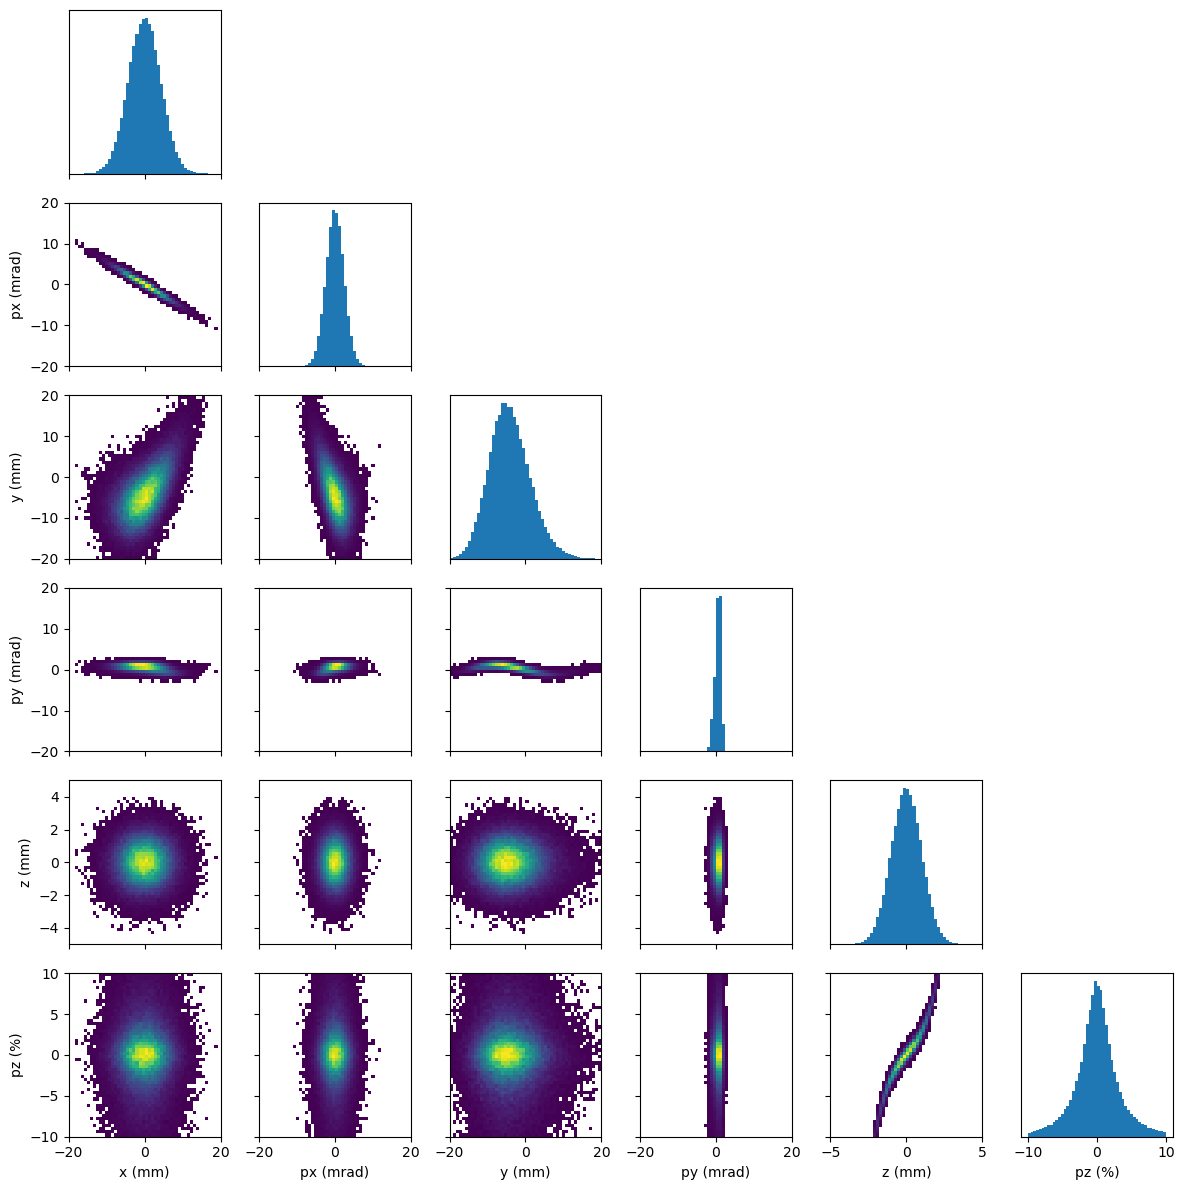

In [3]:
#plot gt beam
lims = np.array([[-20e-3, 20e-3],
                 [-20e-3, 20e-3],
                 [-20e-3, 20e-3],
                 [-20e-3, 20e-3],
                 [-5e-3, 5e-3],
                 [-10e-2, 10e-2]]) 
fig, ax = plot_projections(gt_beam.numpy_particles(), custom_lims=lims)
plt.show()

In [4]:
# diagnostic beamline:
lattice = quad_tdc_bend(p0c=p0c, dipole_on=True)

# Scan over quad strength, tdc on/off and dipole on/off
n_ks = 5
ks = torch.linspace(-10, 10, n_ks) # quad ks
vs = torch.tensor([0, 1e7]) # TDC off/on
gs = torch.tensor([1e-16, 20.0*PI/180.0/0.365]) # dipole off/on
train_params = torch.stack(torch.meshgrid(ks, vs, gs, indexing='ij'))
print(train_params.shape)
print(train_params.unsqueeze(-1).shape)

# create diagnostic screen: 
bins = torch.linspace(-50, 50, 200) * 1e-3
bandwidth = (bins[1]-bins[0]) / 2
screen = ImageDiagnostic(bins, bins, bandwidth)

torch.Size([3, 5, 2, 2])
torch.Size([3, 5, 2, 2, 1])


/global/u1/j/jpga/PS_Reconstruction/phase_space_reconstruction/phase_space_reconstruction/diagnostics.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer("bandwidth", torch.tensor(bandwidth))


In [5]:
# generate and save train and test datasets
train_dset = run_3d_scan(gt_beam, 
                         lattice,
                         screen, 
                         ks, vs, gs, 
                         save_as=os.path.join('data', 'train.dset')
                        )

print(train_dset.params.shape)
print(train_dset.images.shape)

dataset saved as 'data/train.dset'
torch.Size([20, 3, 1])
torch.Size([20, 1, 200, 200])


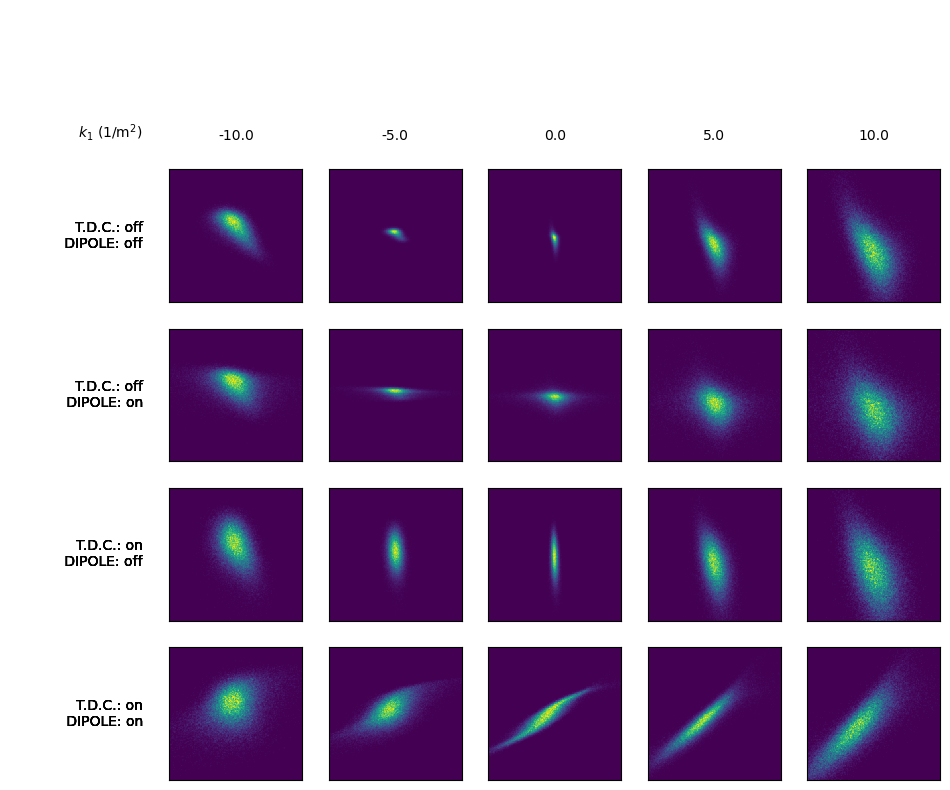

In [6]:
fig, ax = plot_3d_scan_data(train_dset)
plt.show()

In [7]:
# training
pred_beam = train_3d_scan(train_dset, 
                          lattice, 
                          p0c, 
                          screen,
                          n_epochs=1000, 
                          device='cuda')

Using device: cuda


/global/common/software/m669/jpga/conda/envs/ps-reconstruction/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1680572619157/work/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


0 tensor(4037721., device='cuda:0', grad_fn=<MulBackward0>)
100 tensor(546953.5625, device='cuda:0', grad_fn=<MulBackward0>)
200 tensor(512132.4375, device='cuda:0', grad_fn=<MulBackward0>)
300 tensor(467895.5938, device='cuda:0', grad_fn=<MulBackward0>)
400 tensor(505829.2188, device='cuda:0', grad_fn=<MulBackward0>)
500 tensor(469835.8750, device='cuda:0', grad_fn=<MulBackward0>)
600 tensor(441045.6562, device='cuda:0', grad_fn=<MulBackward0>)
700 tensor(447278.1562, device='cuda:0', grad_fn=<MulBackward0>)
800 tensor(474129.8750, device='cuda:0', grad_fn=<MulBackward0>)
900 tensor(502591.4062, device='cuda:0', grad_fn=<MulBackward0>)


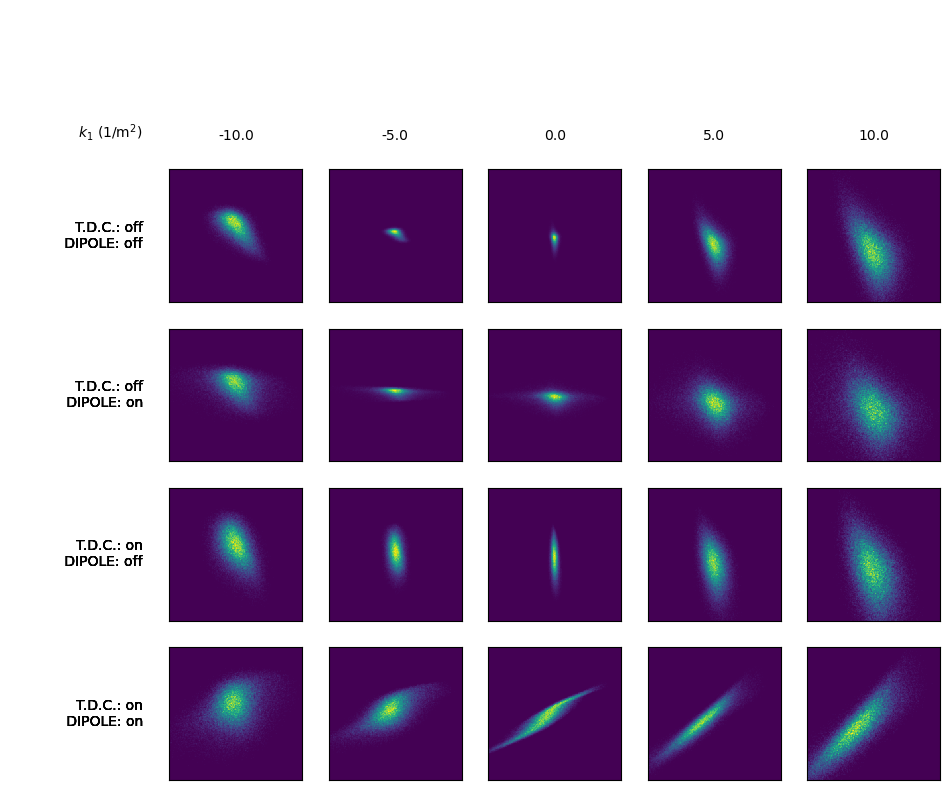

In [8]:
# predicted screens:
pred_dset = run_3d_scan(pred_beam, 
                        lattice,
                        screen, 
                        ks, vs, gs
                        )
fig, ax = plot_3d_scan_data(pred_dset)
plt.show()              

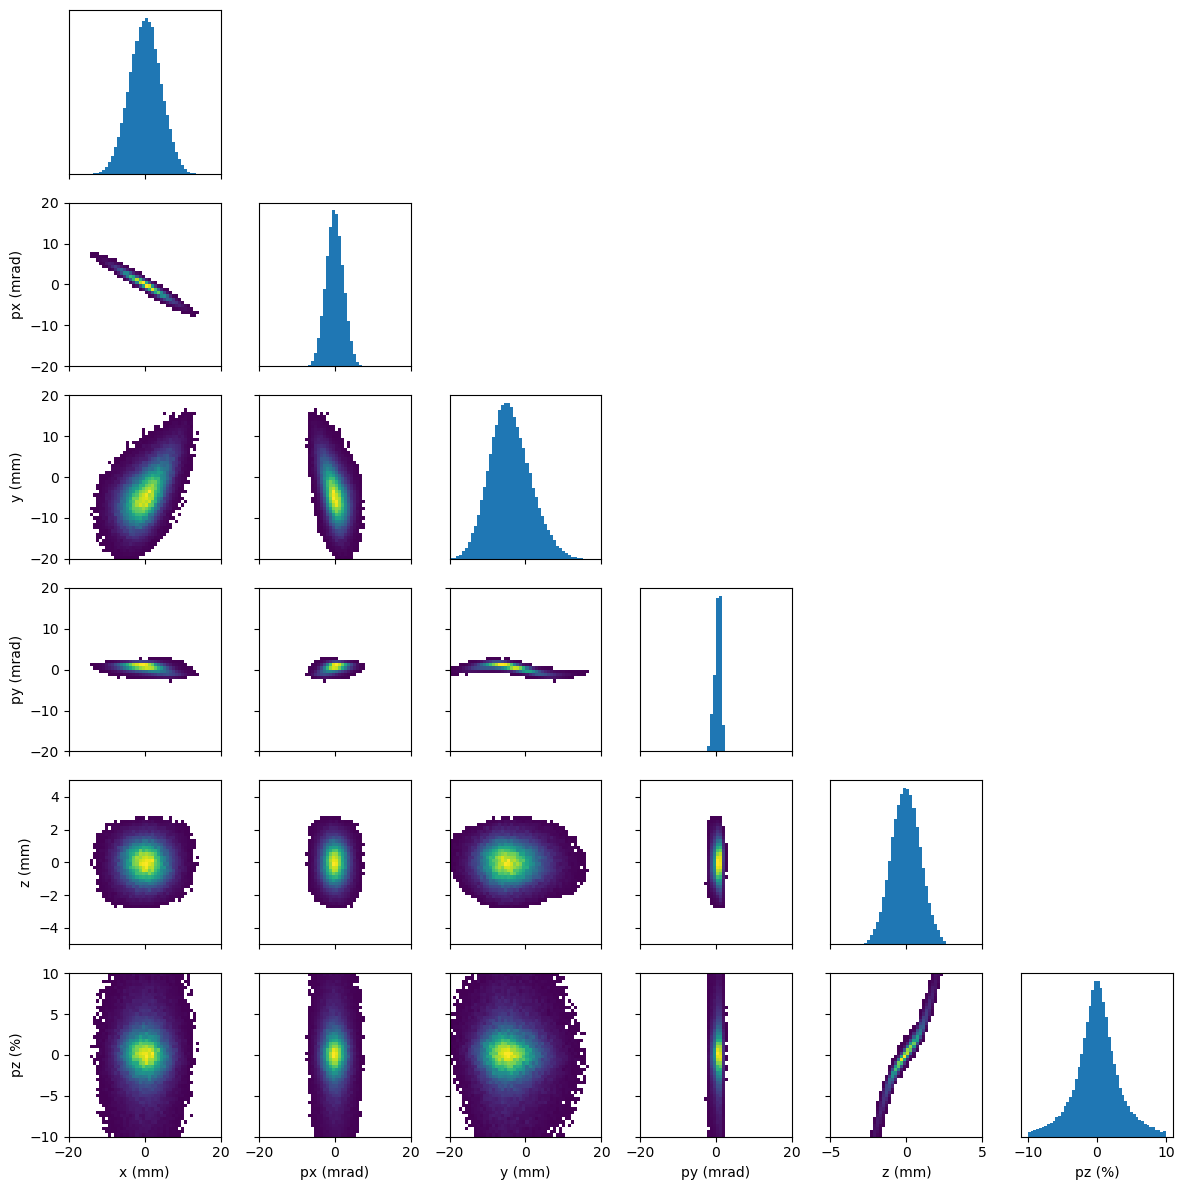

In [9]:
# reconstructed beam projections:
fig, ax = plot_projections(pred_beam.numpy_particles(),
                           custom_lims = lims
                           )
plt.show()

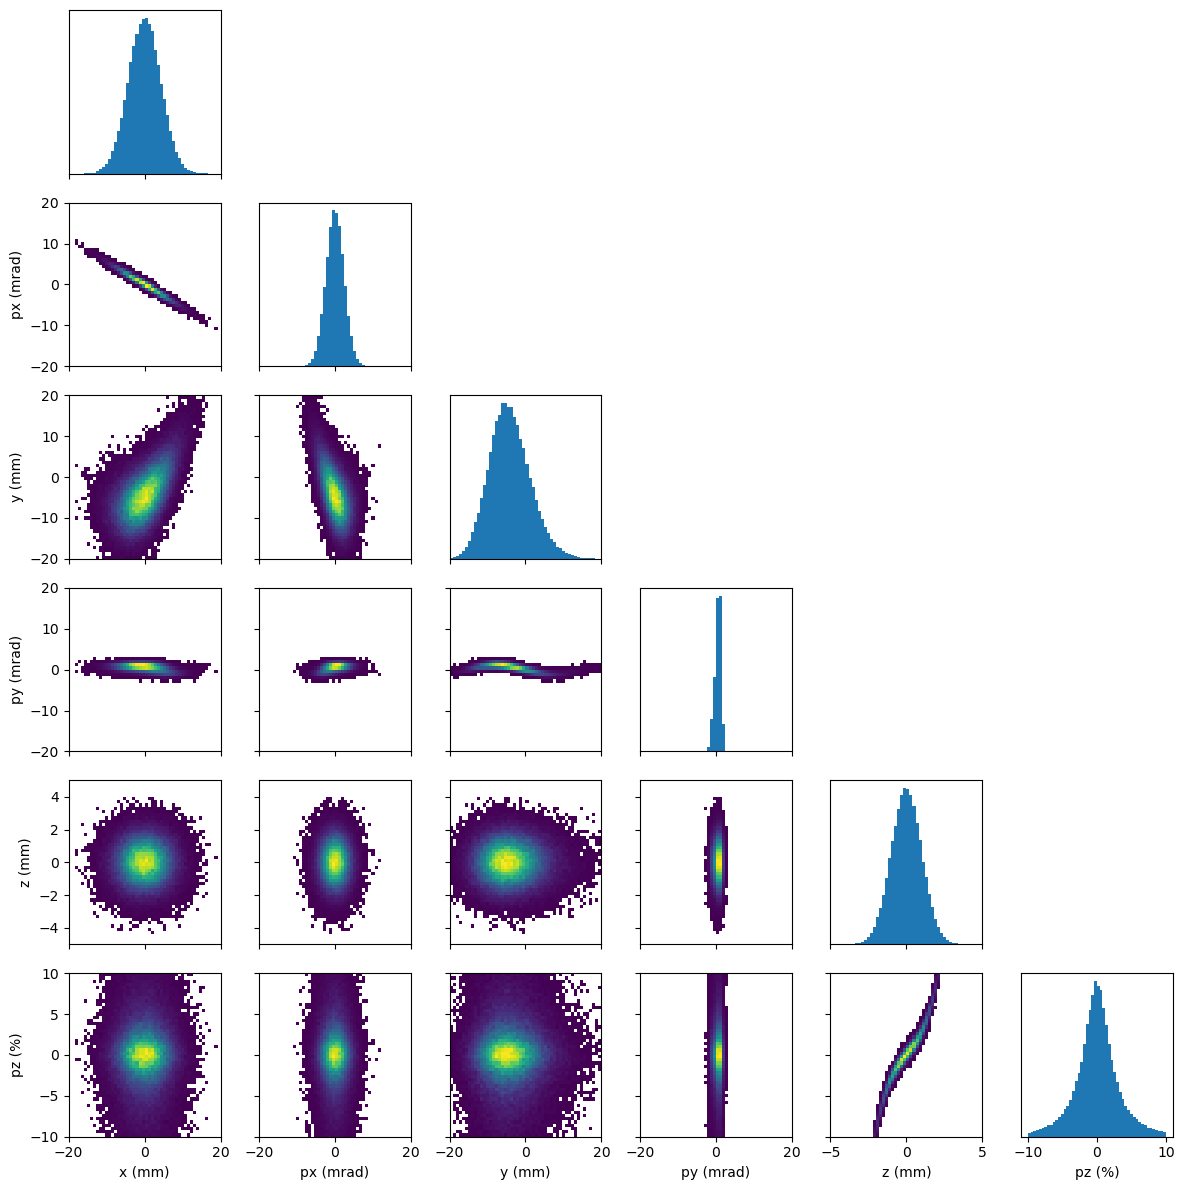

In [10]:
# ground truth beam projections:
fig, ax = plot_projections(gt_beam.numpy_particles(),
                           custom_lims = lims)
plt.show()

In [11]:
torch.cuda.empty_cache()